In [4]:
import sys
import os

# Append the src directory to the system path
sys.path.append(os.path.abspath('../src'))

import pandas as pd
from utils import ip_to_int
from preprocessing import load_data, clean_fraud_data, clean_ip_data

# Load raw data
fraud_df, ip_df = load_data(
    '../data/Fraud_Data.csv',
    '../data/IpAddress_to_Country.csv'
)

# Clean the data as needed
fraud_df = clean_fraud_data(fraud_df)
ip_df = clean_ip_data(ip_df)

# Display the cleaned DataFrame
print(fraud_df.head())

   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class ip_int  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   None  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   None  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1   None  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   None  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   None  


In [5]:
# IP conversion
fraud_df['ip_int'] = fraud_df['ip_address'].apply(ip_to_int)

# Merge IP info
ip_df['lower'] = ip_df['lower_bound_ip_address'].apply(ip_to_int)
ip_df['upper'] = ip_df['upper_bound_ip_address'].apply(ip_to_int)

def find_country(ip_int, ip_df):
    row = ip_df[(ip_df['lower'] <= ip_int) & (ip_df['upper'] >= ip_int)]
    return row['country'].values[0] if not row.empty else 'Unknown'

fraud_df['country'] = fraud_df['ip_int'].apply(lambda x: find_country(x, ip_df))

# Save cleaned version (optional)
fraud_df.to_csv('../data/fraud_cleaned.csv', index=False)
ip_df.to_csv('../data/ip_cleaned.csv', index=False)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
fraud_df = pd.read_csv('../data/fraud_cleaned.csv')

Class Distribution:
 class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


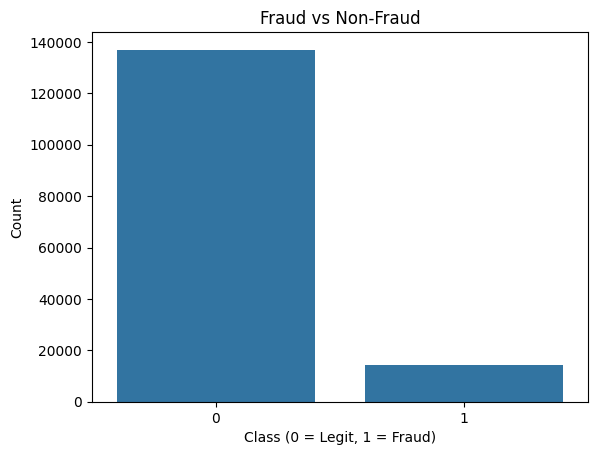

In [5]:
# Class distribution
class_counts = fraud_df['class'].value_counts(normalize=True)
print("Class Distribution:\n", class_counts)

# Plot
sns.countplot(x='class', data=fraud_df)
plt.title('Fraud vs Non-Fraud')
plt.xlabel('Class (0 = Legit, 1 = Fraud)')
plt.ylabel('Count')
plt.savefig("../visuals/class_distribution.png")
plt.show()


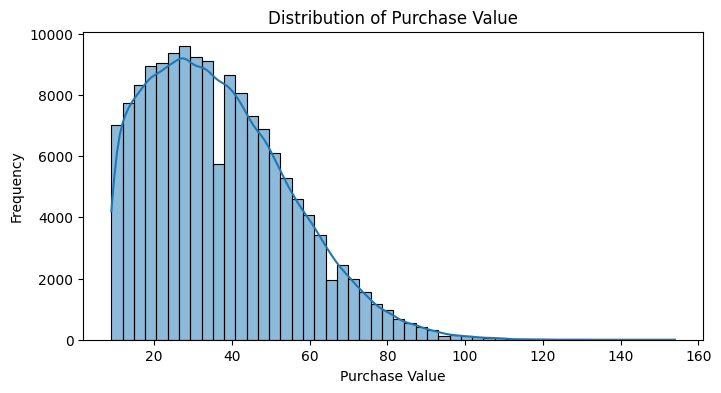

In [7]:
# Histogram of Purchase Value
plt.figure(figsize=(8, 4))
sns.histplot(fraud_df['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.savefig("../visuals/purchase_value_distribution.png")
plt.show()

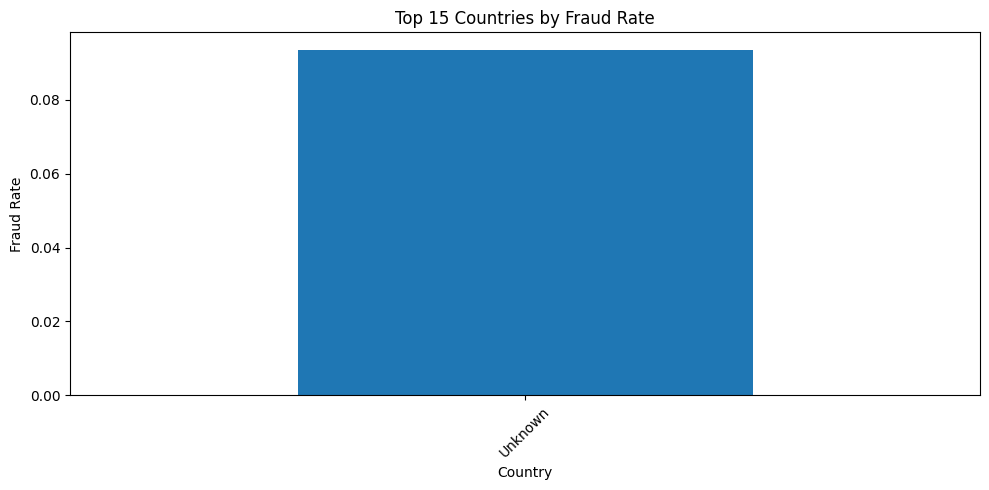

In [12]:
# Fraud rate by country
fraud_rate_country = fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)

# Plot
fraud_rate_country.head(15).plot(kind='bar', figsize=(10, 5))
plt.title('Top 15 Countries by Fraud Rate')
plt.xlabel('Country')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../visuals/fraud_rate_by_country.png")
plt.show()

C:\Users\zeyed\AppData\Local\Temp\ipykernel_20776\3532044973.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fraud_df.set_index('purchase_time').resample('M')['class'].mean().plot(figsize=(10,4))


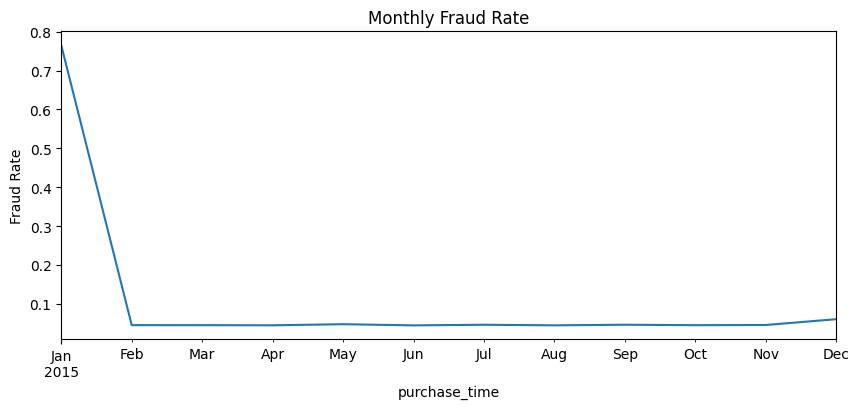

In [21]:
# Convert to datetime if not already
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Plot fraud over time (by month)
fraud_df.set_index('purchase_time').resample('M')['class'].mean().plot(figsize=(10,4))
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.savefig("../visuals/monthly_fraud_rate.png")
plt.show()

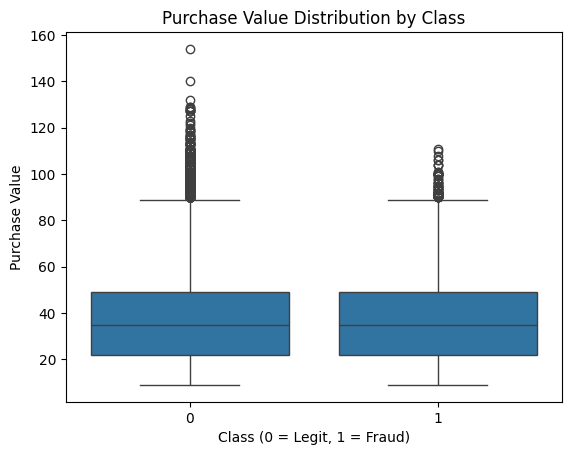

In [20]:
# Boxplot: Purchase Value by Class
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value Distribution by Class')
plt.xlabel('Class (0 = Legit, 1 = Fraud)')
plt.ylabel('Purchase Value')
plt.savefig("../visuals/purchase_value_by_class.png")
plt.show()

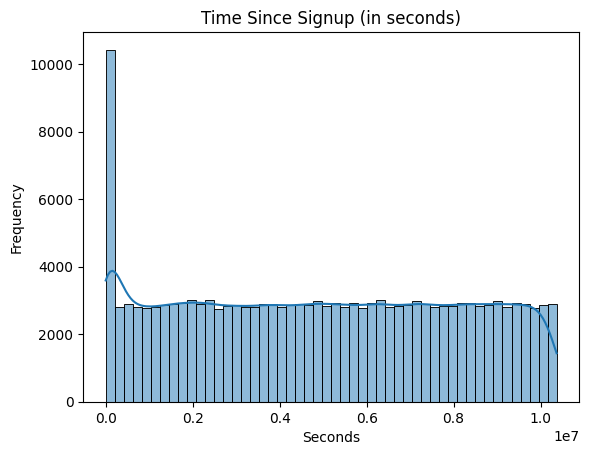

In [19]:
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

# Plot the distribution
sns.histplot(fraud_df['time_since_signup'], bins=50, kde=True)
plt.title('Time Since Signup (in seconds)')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.savefig("../visuals/time_since_signup.png")
plt.show()

In [18]:
fraud_df.to_csv('../data/fraud_featurized.csv', index=False)